In [13]:
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse

import pytesseract
%matplotlib inline

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == 'bottom-to-top':
        reverse = True
        
    if method == "left-to-right" or method == 'top-to-bottom':
        i = 1
        
    boundingBoxes = [cv2.boundingRect(c) for c in cnts] # 用一个最小的矩形，把找到的形状包起来x,y,h,w
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    
    return cnts, boundingBoxes


def cv_show(img, name='img'):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    

def order_points(pts):
    # 一共4个坐标点
    rect = np.zeros((4, 2), dtype="float32")
    # 按顺序找到对应坐标0123分别是左上、右上、右下、左下
    # 计算左上、右下
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # 计算右上、左下
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def four_point_transform(image, pts):
    # 获取输入坐标点
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # 计算输入的w和h值
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # 变换后对应坐标位置
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    # 计算变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

    

In [2]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", help="path to input image",required=True)
args = ap.parse_args(['-i','src/img/ticket2.jpeg'])

In [3]:
image = cv2.imread(args.image)

In [4]:
# 坐标会相同变化
ratio = image.shape[0] / 500.0
orig = image.copy()

image = resize(orig, height=500)

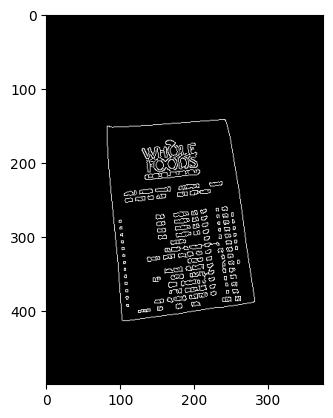

In [5]:
# 预处理
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

plt.imshow(edged,cmap='gray')

In [6]:
# 轮廓检测
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

In [7]:
# 遍历轮廓
for c in cnts:
    # 计算轮廓近似
    peri = cv2.arcLength(c, True)
    # c表示输入的点集
    # epsilon表示从原始轮廓到近似轮廓的最大距离，是一个准确的参数
    # True表示封闭
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    # 4个点的时候就拿出来
    if len(approx) == 4:
        screenCnt = approx
        break

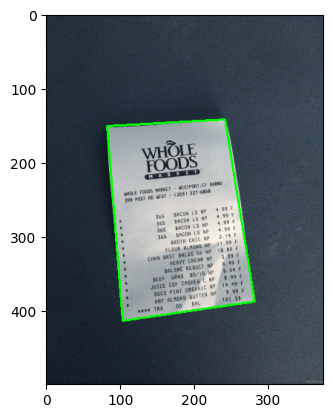

In [8]:
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image)

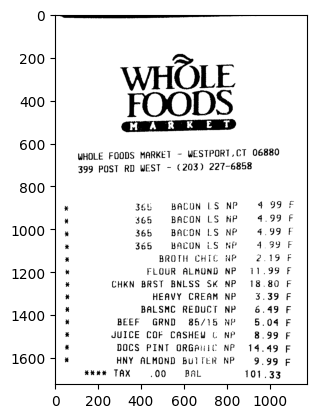

In [11]:
# 透视变换
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
# 二值处理
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(warped, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(ref, cmap='gray')

42 ag WESTPORT CT 06880

WHOLE FOODS MAR
399 POs! RD WEST ~ (203) 221-6858

CSON @Aaron.ywi



(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fd315631810>)

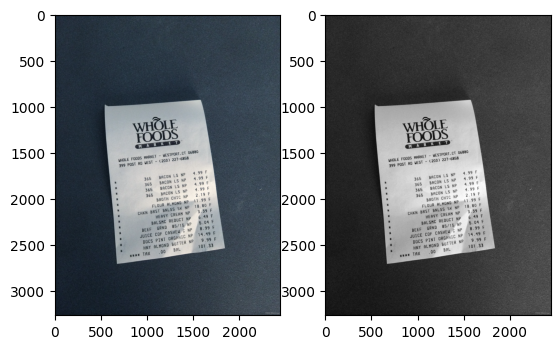

In [16]:
# ocr识别
preprocess = 'blur'
# preprocess = 'thresh'

image = cv2.imread(args.image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if preprocess == 'thresh':
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
if preprocess == 'blur':
    gray = cv2.medianBlur(gray, 3)
    
filename = '{}.png'.format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename))
print(text)
os.remove(filename)

plt.subplot(121), plt.imshow(image, cmap='gray')
plt.subplot(122), plt.imshow(gray, cmap='gray')